# Congressmen notebook

Parses datasets/camara/congressmen_with_memberships.json creating / updating the following polare entites:
* Agents
* Memberships (Congress, Parties)
* Organizations (Camara)
* Posts (Camara)
* Roles (Afiliado, Deputado)

 ## 1. Imports and Constants Declaration

In [96]:
import json 
import pandas as pd
from collections import deque, defaultdict
from uuid import uuid4

import matplotlib.pyplot as plt

termid = 55 # legislatura
start_date = '2015-01-02'

PROV = 'cam'
JSON_PATH =  'datasets/camara/json/'

AGENTS_PATH = 'datasets/slp/agents/'
MEMBERSHIPS_PATH = 'datasets/slp/memberships/'
ORGANIZATIONS_PATH = 'datasets/slp/organizations/'
POSTS_PATH = 'datasets/slp/posts/'

FILE_SUFFIX = '55'
CAMARA_URI = 'c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c' 


 ## 2. Getting the Parties

In [97]:
filename = 'parties.csv'
file_path = '{:}{:}'.format(ORGANIZATIONS_PATH, filename)
df_parties = pd.read_csv(file_path, sep= ';', encoding= 'utf-8', index_col=None)
df_parties.set_index('sigla', inplace=True)


parties_d = df_parties['slp:resource_uri'].to_dict()                        
print({k:parties_d[k]
    for k in ['PT', 'PMDB', 'DEM']})

{'PT': '7b2138a6-df61-11e7-baf1-c82a144c0a85', 'PMDB': '7b210cfa-df61-11e7-9864-c82a144c0a85', 'DEM': '7b20ed7e-df61-11e7-bb65-c82a144c0a85'}


## 3. Reads scrapped json

In [98]:
filename = 'congressman_with_memberships-{:}.json'.format(FILE_SUFFIX) 
file_path = '{:}{:}'.format(JSON_PATH, filename)
with open(file_path, mode='r') as f:
    senatorsstr = f.read()
f.close()

congressmen_with_memberships = json.loads(senatorsstr)

## 4. Agents

In [99]:
mapping = {
  'slp:resource_uri': 'slp:resource_uri',           
  'cam:ideCadastro': 'cam:ideCadastro',
  'cam:nomeCivil':'cam:nomeCivil',
  'cam:nomeParlamentarAtual':'cam:nomeParlamentarAtual',
  'cam:dataNascimento': 'cam:dataNascimento',
  'cam:dataFalecimento': 'cam:dataFalecimento',
}

agents = [] 
for cwm_d in congressmen_with_memberships:
    agent_d = {mapping[k]: cwm_d.get(k, None) for k in mapping}
    if agent_d:
        agents.append(agent_d)

filename = 'congressmen-{:}-{:}.csv'.format(PROV, FILE_SUFFIX) 
file_path = '{:}{:}'.format(AGENTS_PATH, filename)
df = pd.DataFrame.from_dict(agents)    
print('found {:} congressmen.'.format(df.shape[0]))
df.to_csv(file_path, sep=';', encoding='utf-8', index=None)
df.head()

found 606 congressmen.


,cam:dataFalecimento,cam:dataNascimento,cam:ideCadastro,cam:nomeCivil,cam:nomeParlamentarAtual,slp:resource_uri
0,None,1976-10-23,178836,ALAN RICK MIRANDA,ALAN RICK,64965d06-916a-4ef9-a8c7-886055dc979e
1,None,1969-02-13,160527,AGUINALDO VELLOSO BORGES RIBEIRO,AGUINALDO RIBEIRO,908bcac7-6fc7-4957-9ae9-00a46ad10a37
2,None,1987-02-10,160582,JOSÉ ALBERTO OLIVEIRA VELOSO FILHO,ALBERTO FILHO,5ff9cfe9-2fee-47b6-b7ac-a1cb282236be
3,None,1960-10-15,160508,AFONSO BANDEIRA FLORENCE,AFONSO FLORENCE,e4e93a22-8177-400a-8231-2e8ae9d06a12
4,None,1956-02-05,178903,ADILTON DOMINGOS SACHETTI,ADILTON SACHETTI,0a39e693-7990-4118-8637-278d778df124


 ## 5. Congress Memberships
 
 ### 5.1 Membership Preprocess

In [100]:
mapping = {
    'cam:siglaUFRepresentacao': 'cam:siglaUFRepresentacao',
    'cam:dataInicio': 'cam:dataInicio', 
    'cam:dataFim': 'cam:dataFim',
    'slp:resource_uri':'slp:resource_uri',
    'org:role':'org:role'
}

memberships = [] 
for cwm_d in congressmen_with_memberships:
    member_uri = cwm_d['slp:resource_uri'] 
    terms = cwm_d['terms']
    if terms:
        for term_d in terms:
            memberships_d = {mapping[k]: term_d.get(k, None) for k in mapping}
            if memberships_d:
                memberships_d['org:member'] = member_uri
                memberships.append(memberships_d)


memberships = sorted(memberships, key=lambda x:x['cam:dataInicio'])
filename = 'memberships_with_congress-{:}-{:}.csv'.format(PROV, FILE_SUFFIX) 
file_path = '{:}{:}'.format(MEMBERSHIPS_PATH, filename)
df = pd.DataFrame.from_dict(memberships)    
print('number of memberships:'.format(df.shape[0]))
df.head()            

number of memberships:


,cam:dataFim,cam:dataInicio,cam:siglaUFRepresentacao,org:member,org:role,slp:resource_uri
0,None,2015-02-01,AC,64965d06-916a-4ef9-a8c7-886055dc979e,b27beba7-ca02-4041-a9e0-1793bcd141fe,9589fe93-2270-4940-be3c-706111bf6b69
1,None,2015-02-01,PB,908bcac7-6fc7-4957-9ae9-00a46ad10a37,b27beba7-ca02-4041-a9e0-1793bcd141fe,e896acb8-0da3-4e4a-b235-355c1a01f7cb
2,None,2015-02-01,BA,e4e93a22-8177-400a-8231-2e8ae9d06a12,b27beba7-ca02-4041-a9e0-1793bcd141fe,30eb6da8-3308-45a0-bfd8-0f6f9884133c
3,2017-10-30,2015-02-01,MT,0a39e693-7990-4118-8637-278d778df124,b27beba7-ca02-4041-a9e0-1793bcd141fe,76e294dc-7b1a-48d5-8f15-6888f59c42d2
4,None,2015-02-01,RS,abf442cf-ef29-40f6-8929-9a4066570ed2,b27beba7-ca02-4041-a9e0-1793bcd141fe,39df2d4d-6954-4abf-909f-7ab27d22870f


 ### 5.2  Processing Congress Posts

There are currently 513 Posts at Camara. The total should be fixed but in practice it's not. Our first task is to determine the max number of posts and than allocating them accordingly.

In [101]:
def cumsum(lis):
    total = 0
    for x in lis:
        total += x
        yield total
        
ts_open = pd.pivot_table(df, index='cam:dataInicio',aggfunc=len)['cam:dataFim']
ts_open.index.names = ['time']
ts_open.name = 'new'

ts_close = pd.pivot_table(df, index='cam:dataFim',aggfunc=len)['cam:dataInicio']
ts_close.index.names = ['time']
ts_close.name = 'expired'

df = ts_open.to_frame().join(ts_close.to_frame(), how='outer').fillna(0)
df['total'] = list(cumsum(df['new'] - df['expired']))
print('Max posts:', max(df['total']))
df.head()




Max posts: 520.0


,new,expired,total
time,,,
2015-02-01,517.0,0.0,517.0
2015-02-02,0.0,4.0,513.0
2015-02-03,6.0,7.0,512.0
2015-02-04,8.0,5.0,515.0
2015-02-05,1.0,3.0,513.0


 ### 5.3  Congress Posts Plot

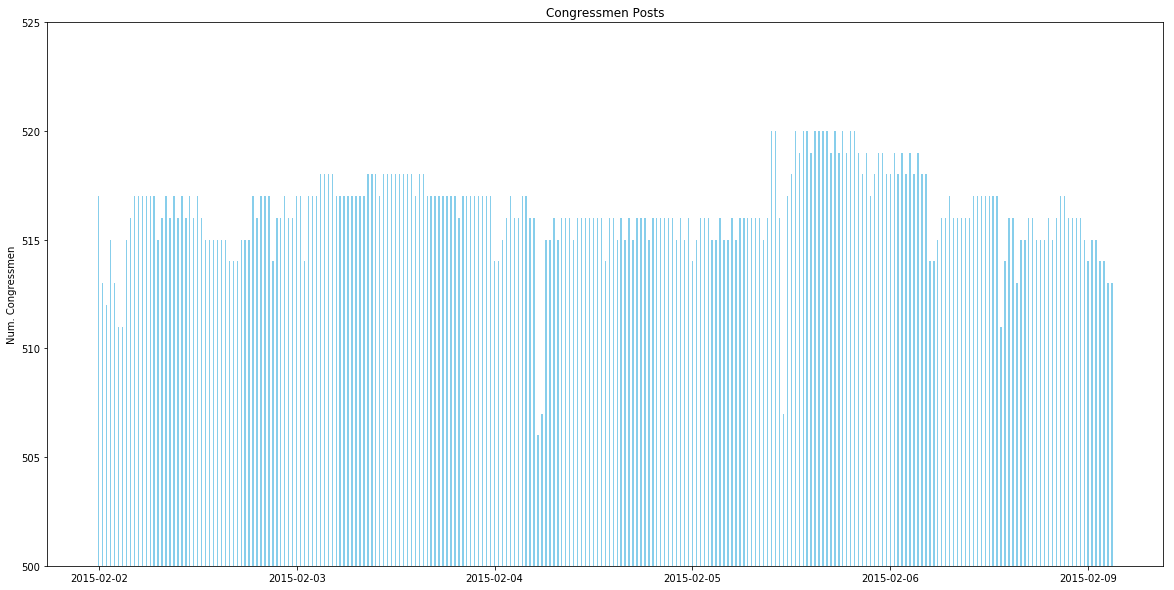

In [102]:
fig, ax = plt.subplots(figsize=(20, 10))
ind = range(df.shape[0])
width = 0.35  # the width of the bars

rects1 = ax.bar(ind, df['total'].values, width, color='SkyBlue')
ax.set_ylabel('Num. Congressmen')
ax.set_title('Congressmen Posts')
ax.set_xticklabels(df['total'].index)

plt.ylim([500, 525])
plt.show()

 ### 5.4  Congress Posts Allocation
 
 We create a queue of posts and allocate them as necessary.

In [103]:
maxlen= int(max(df['total']))
posts = deque([str(uuid4()) for _ in range(maxlen)], maxlen=maxlen)
posts_expired = defaultdict(deque)

# Sort by dataInicio 
memberships = sorted(memberships, key=lambda x:x['cam:dataInicio'])
dates = df.index.tolist()
prevdate = '1800-01-01'
for d in memberships:
    start = d['cam:dataInicio']
    finish = d['cam:dataFim']
    # either the start date is in posts_expired
    # or some posts have become available
    processdates = [date for date in dates 
                         if date >= prevdate and date <= start]        
    for procdate in processdates:
        if procdate in posts_expired:
            try:
                # pops from expired until empty
                while True:      
                    post_uri = posts_expired[procdate].pop()
                    posts.append(post_uri)
            except IndexError: 
                i=0
    
    post_uri = posts.pop()
    d['org:post'] = post_uri
    d['org:postIn'] = CAMARA_URI
    if finish: # push for a future date        
        posts_expired[finish].append(d['org:post'])
    prevdate = start


df = pd.DataFrame.from_dict(memberships)    
df.head()    

,cam:dataFim,cam:dataInicio,cam:siglaUFRepresentacao,org:member,org:post,org:postIn,org:role,slp:resource_uri
0,None,2015-02-01,AC,64965d06-916a-4ef9-a8c7-886055dc979e,225f4caf-92a0-458b-bbbf-deb1e27c6e06,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c,b27beba7-ca02-4041-a9e0-1793bcd141fe,9589fe93-2270-4940-be3c-706111bf6b69
1,None,2015-02-01,PB,908bcac7-6fc7-4957-9ae9-00a46ad10a37,0895c168-ebf1-445c-9614-bcefa85e19a5,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c,b27beba7-ca02-4041-a9e0-1793bcd141fe,e896acb8-0da3-4e4a-b235-355c1a01f7cb
2,None,2015-02-01,BA,e4e93a22-8177-400a-8231-2e8ae9d06a12,bde0b5b4-4ff9-4e26-ae02-196d1c477a47,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c,b27beba7-ca02-4041-a9e0-1793bcd141fe,30eb6da8-3308-45a0-bfd8-0f6f9884133c
3,2017-10-30,2015-02-01,MT,0a39e693-7990-4118-8637-278d778df124,936e787a-e8b1-4763-b4c2-529cf94f971e,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c,b27beba7-ca02-4041-a9e0-1793bcd141fe,76e294dc-7b1a-48d5-8f15-6888f59c42d2
4,None,2015-02-01,RS,abf442cf-ef29-40f6-8929-9a4066570ed2,9f39618a-e605-4d5d-b22b-fb6187423a0b,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c,b27beba7-ca02-4041-a9e0-1793bcd141fe,39df2d4d-6954-4abf-909f-7ab27d22870f


 ### 5.5  Congress Posts Save

In [104]:
filename = 'memberships_with_congress-{:}-{:}.csv'.format(PROV, FILE_SUFFIX) 
file_path = '{:}{:}'.format(MEMBERSHIPS_PATH, filename)
df.to_csv(file_path, sep=';', encoding='utf-8', index=None)

 ## 6. Party Memberships

 ### 6.1 Membership Process

In [105]:
mapping = {
    'cam:sigla': 'cam:sigla',
    'cam:dataInicio': 'cam:dataInicio', 
    'cam:dataFim': 'cam:dataFim',
    'slp:resource_uri':'slp:resource_uri',
    'org:role':'org:role'
}

memberships = [] 
for cwm_d in congressmen_with_memberships:
    member_uri = cwm_d['slp:resource_uri'] 
    affiliations = cwm_d['affiliations']
    if affiliations:
        for affiliation_d in affiliations:
            memberships_d = {mapping[k]: affiliation_d.get(k, None) for k in mapping}
            if memberships_d:
                memberships_d['org:member'] = member_uri
                memberships_d['org:post'] = str(uuid4())
                memberships_d['org:postIn'] = parties_d[affiliation_d['cam:sigla']]
                memberships.append(memberships_d)


df = pd.DataFrame.from_dict(memberships)   
df.head()

,cam:dataFim,cam:dataInicio,cam:sigla,org:member,org:post,org:postIn,org:role,slp:resource_uri
0,None,None,PRB,64965d06-916a-4ef9-a8c7-886055dc979e,328b3a12-d3f7-499a-879f-8c179ddb12c6,7b211b34-df61-11e7-b235-c82a144c0a85,ebf7f8f0-1b0a-4662-9ed8-c9bb19936ec0,fe42e2cd-dfab-43be-be18-cb88180637fe
1,None,None,DEM,64965d06-916a-4ef9-a8c7-886055dc979e,51ffcb0c-0b54-468e-a6af-686e219ca455,7b20ed7e-df61-11e7-bb65-c82a144c0a85,ebf7f8f0-1b0a-4662-9ed8-c9bb19936ec0,db643c02-6940-41c0-b668-fee9d4ae20b4
2,None,None,PP,908bcac7-6fc7-4957-9ae9-00a46ad10a37,2dfb4948-cec3-40a7-b38d-522e172f692c,7b21152e-df61-11e7-bdcf-c82a144c0a85,ebf7f8f0-1b0a-4662-9ed8-c9bb19936ec0,f5193800-cd60-453b-b9c2-add0ec7f27d3
3,None,None,PMDB,5ff9cfe9-2fee-47b6-b7ac-a1cb282236be,afe6c320-e190-471f-9984-96cd68859d29,7b210cfa-df61-11e7-9864-c82a144c0a85,ebf7f8f0-1b0a-4662-9ed8-c9bb19936ec0,e6279cfe-789b-49c5-959a-49f14bea2571
4,None,None,PT,e4e93a22-8177-400a-8231-2e8ae9d06a12,22e5eb10-0c65-47a4-a344-93f271b0fbeb,7b2138a6-df61-11e7-baf1-c82a144c0a85,ebf7f8f0-1b0a-4662-9ed8-c9bb19936ec0,3bc84a72-bbf1-4cda-8833-7e94d7c8b234


 ### 6.2 Membership Save

In [106]:
filename = 'memberships_with_parties-{:}-{:}.csv'.format(PROV, FILE_SUFFIX) 
file_path = '{:}{:}'.format(MEMBERSHIPS_PATH, filename)
df.to_csv(file_path, sep=';', encoding='utf-8', index=None)